# Quality Control
The purpose of this notebook is to execute a rigorous quality control (QC) process upon the dataset to ensure it is consistent, complete, and user-friendly for both humans and computers. The QC process attempts to verify that the data produced meets the SNAP Quality Data Standard. This includes verify metadata is constant across the dataset. This means that each GeoTIFF must have identical header information, spatial extent, coordinate reference system, NoData value, compression, and spatial resolution.

In [1]:
import os
import re
import rasterio as rio
import threading
import concurrent.futures
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from rasterio.plot import show
from config import reprojected_dir, metrics

In [2]:
qc_fps = [x for x in Path(reprojected_dir).glob("*.tif")]

In [3]:
def metadata_check(directory):
    all_meta = []
    fps = [x for x in directory.glob("*.tif")]
    read_lock = threading.Lock()

    def process(fp):
        src = rio.open(fp)
        with read_lock:
            profile = src.profile
            all_meta.append(profile)
    
    # We map the process() function over the list of files
    with concurrent.futures.ThreadPoolExecutor(max_workers=24) as executor:
        executor.map(process, fps)
    return all_meta

In [4]:
%%time
meta = metadata_check(reprojected_dir)

CPU times: user 50.2 s, sys: 11.6 s, total: 1min 1s
Wall time: 1min 9s


In [5]:
assert len(meta) == len(qc_fps)
assert(all([x == meta[0] for x in meta]) == True)

### Verify the dataset passes the eyeball test

It is good practice to verify that the data have visual integrity: spatial bounds and patterns of data values should be reasonable for the geographic area and type of quantity or variable represented by the data. These figures are a good way to share progress on a dataset with others as well. There are many variables that we need to examine individually in this dataset. While we can't look at tens of thousands of GeoTIFFs, we will randomly sample nine GeoTIFFs from each of the variables. For the sampled data we will also generate histograms so we can connect the map visualization to the underlying statistical distribution.

In [6]:
def plot_maps(var):
    fig, axs = plt.subplots(3, 3, figsize=(14, 9), sharex=True, sharey=True)
    var_fps = [x for x in qc_fps if var in x.name]
    
    arrs = []
    titles = []
    for ax in axs.flatten():
        i = np.random.randint(len(var_fps))
        fp = var_fps[i]
        with rio.open(fp) as src:
            show(src, ax=ax, interpolation="none")
            arrs.append(src.read(1))
        title = fp.name[10:-4]
        ax.set_title(title)
        titles.append(title)

    plt.show()
    
    return arrs, titles


def plot_histograms(arrs, titles):
    fig, axs = plt.subplots(3, 3, figsize=(12, 12))
    for ax, arr, title in zip(axs.flatten(), arrs, titles):
        arr = arr.flatten()
        arr = arr[arr != -9999]
        ax.hist(arr)
        ax.set_title(title)

    plt.show()

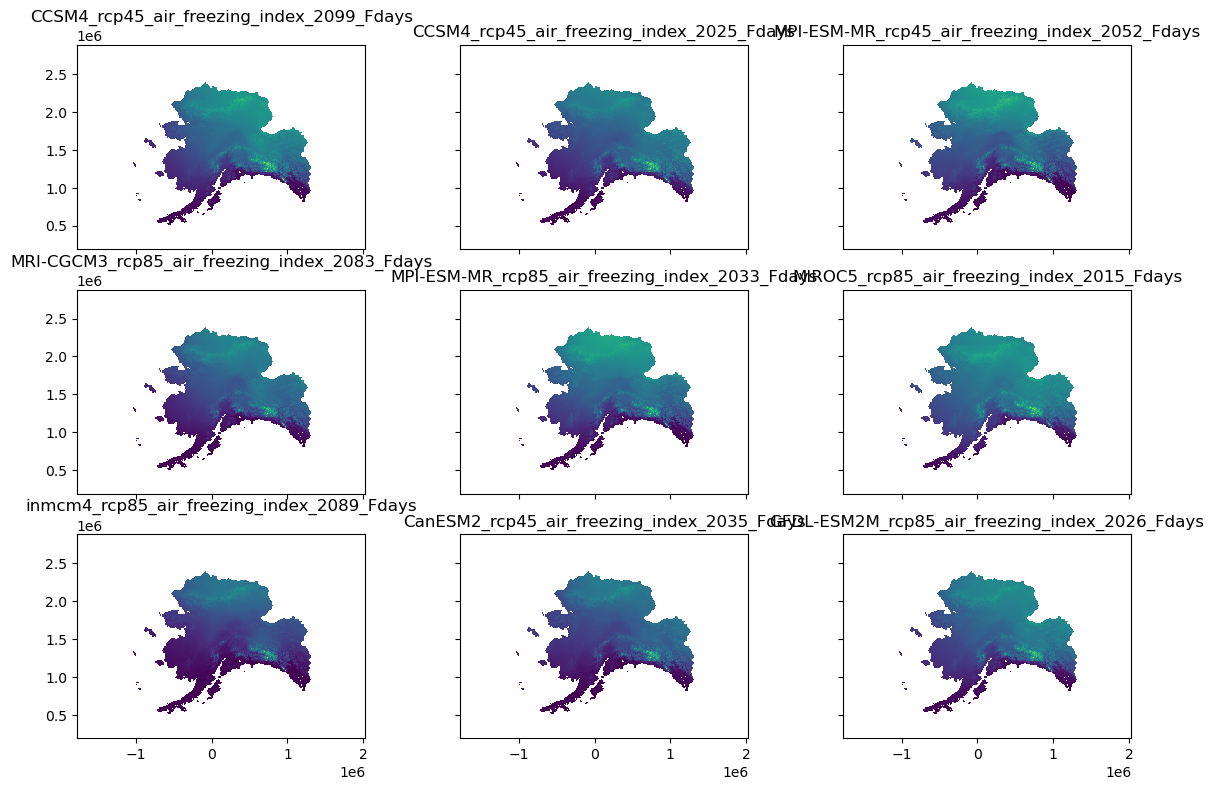

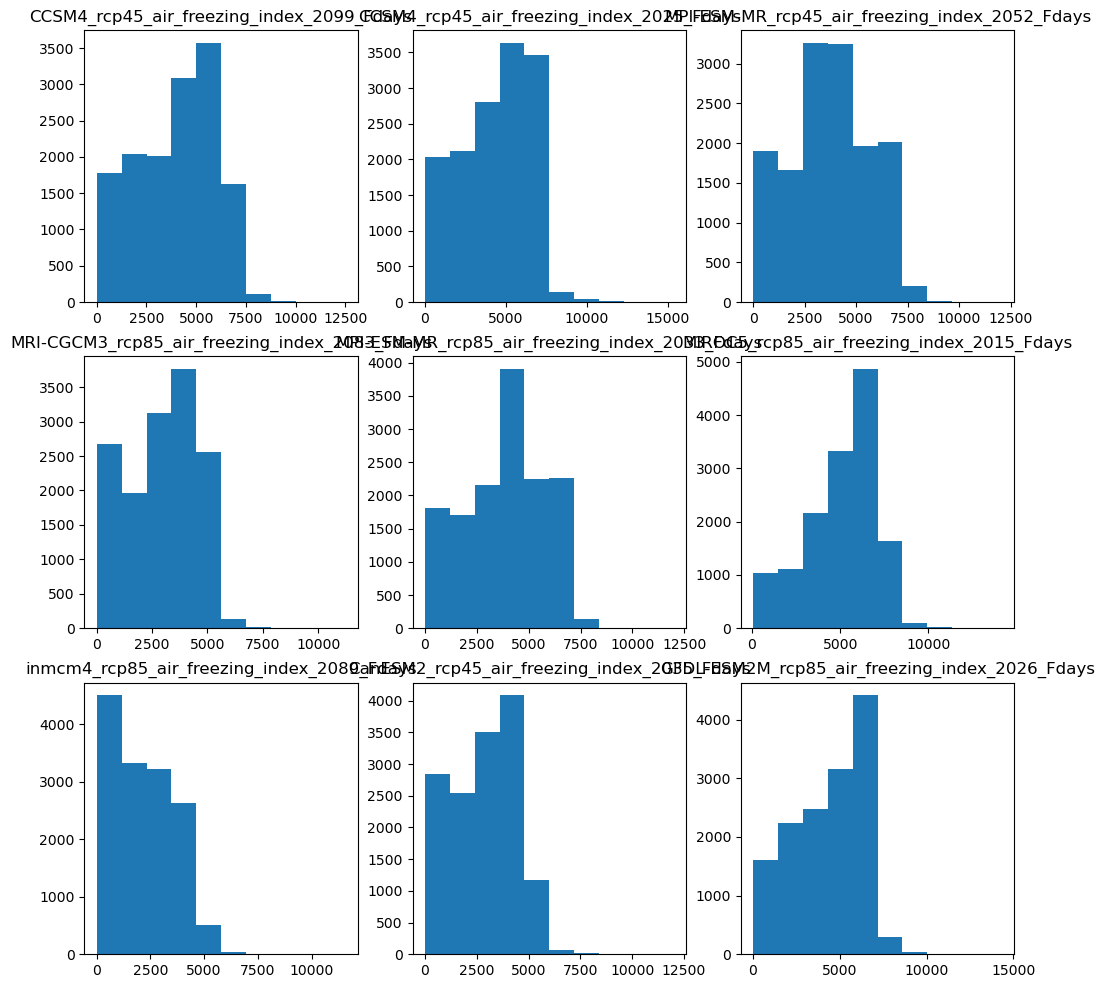

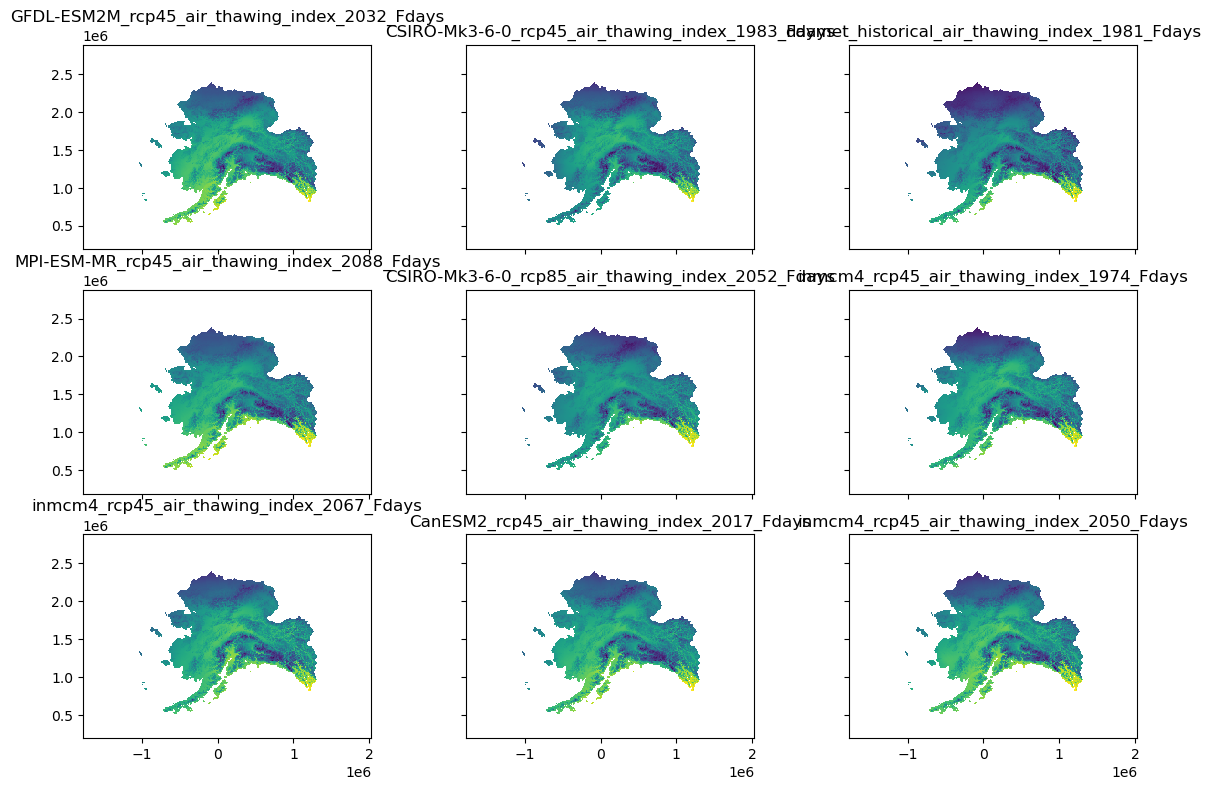

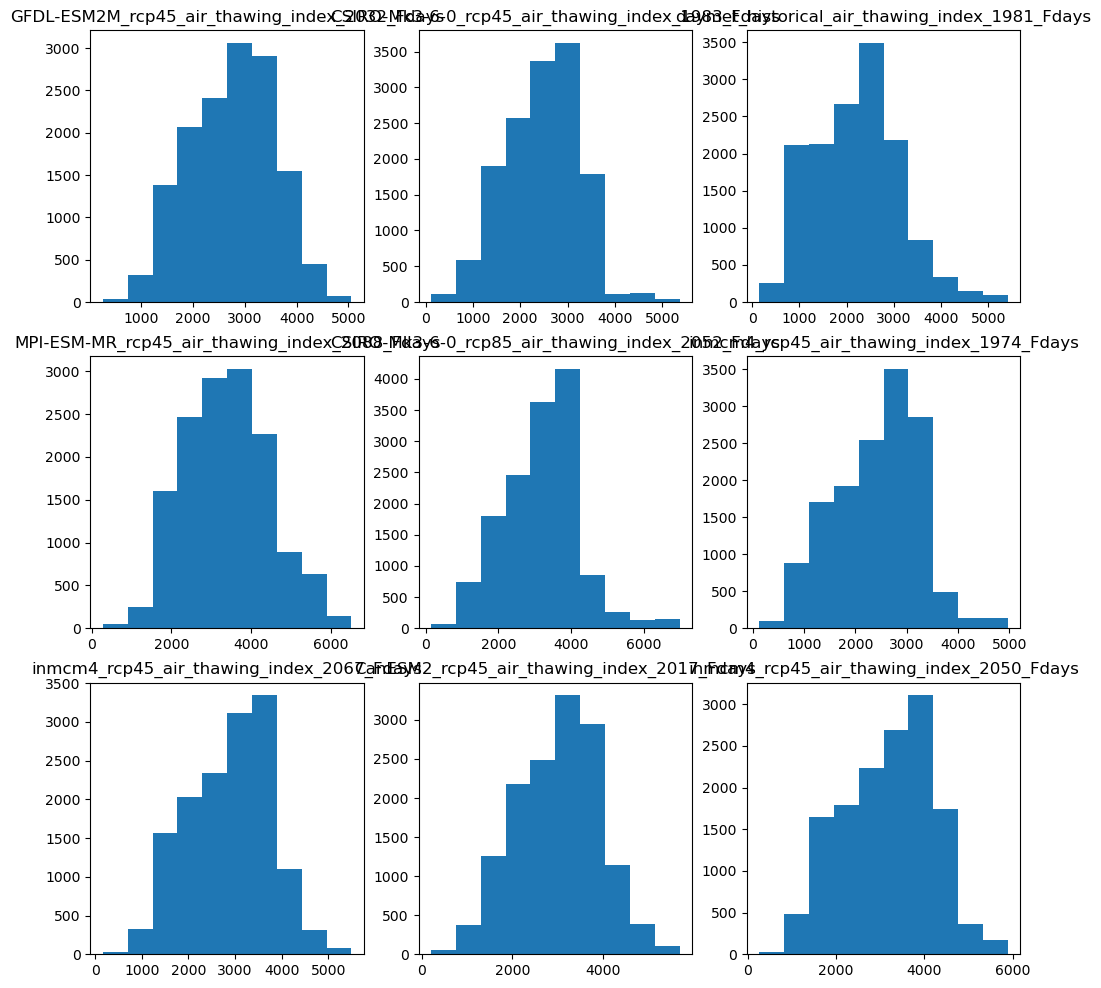

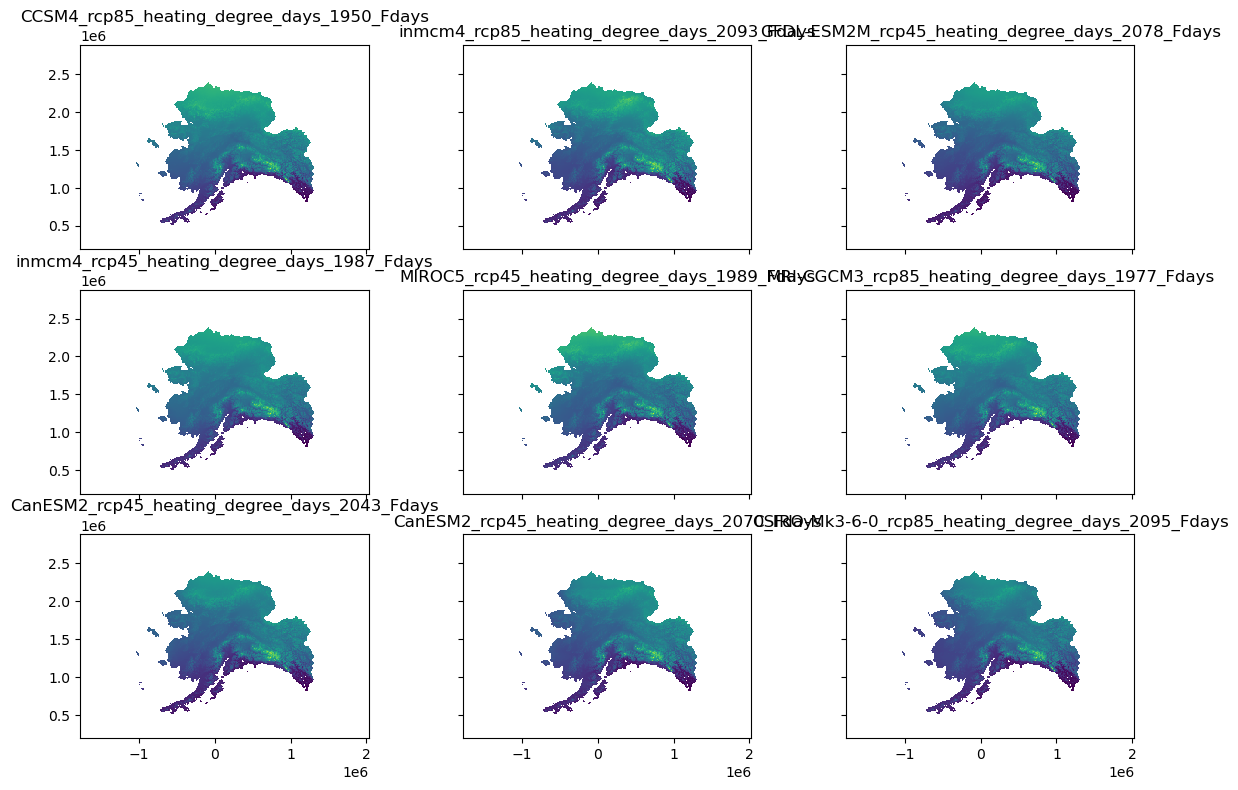

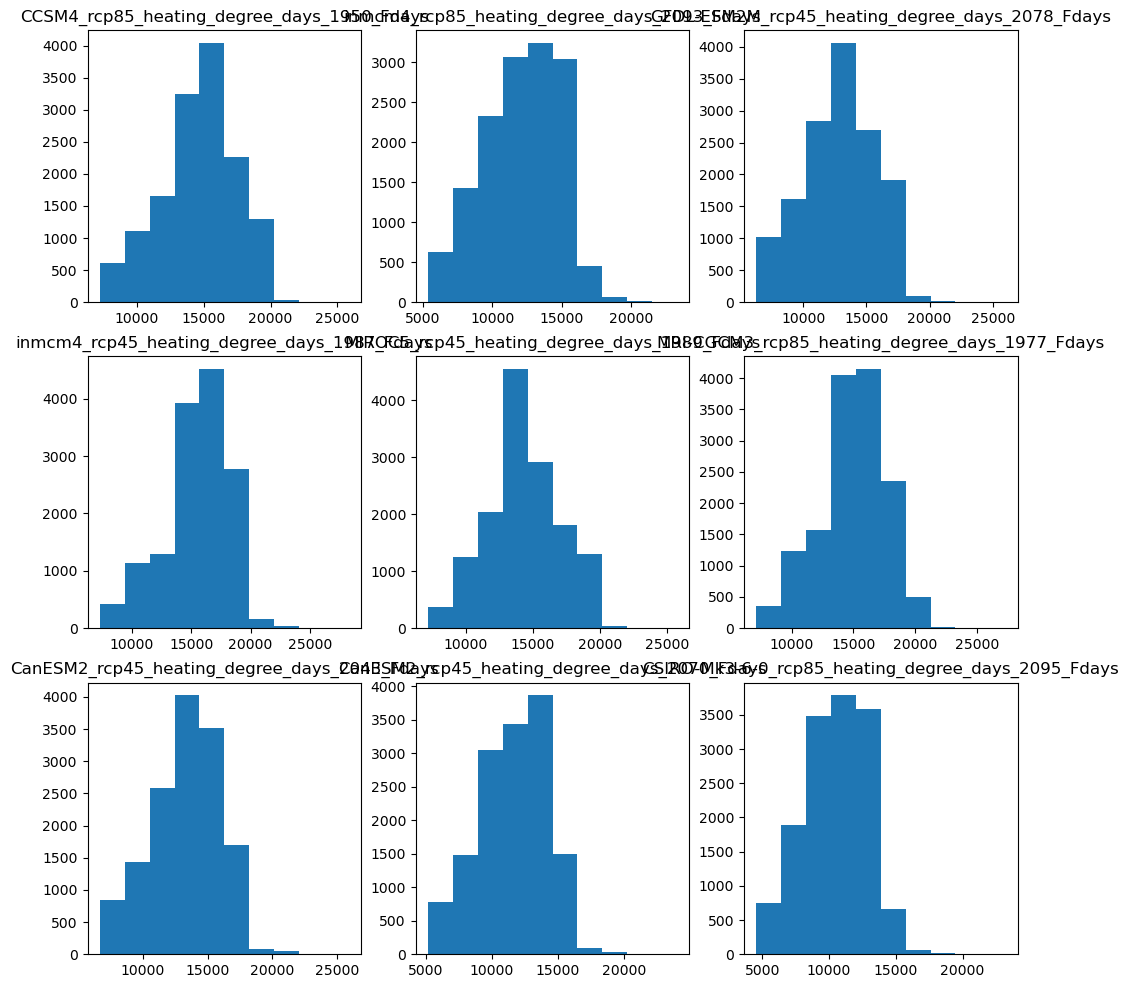

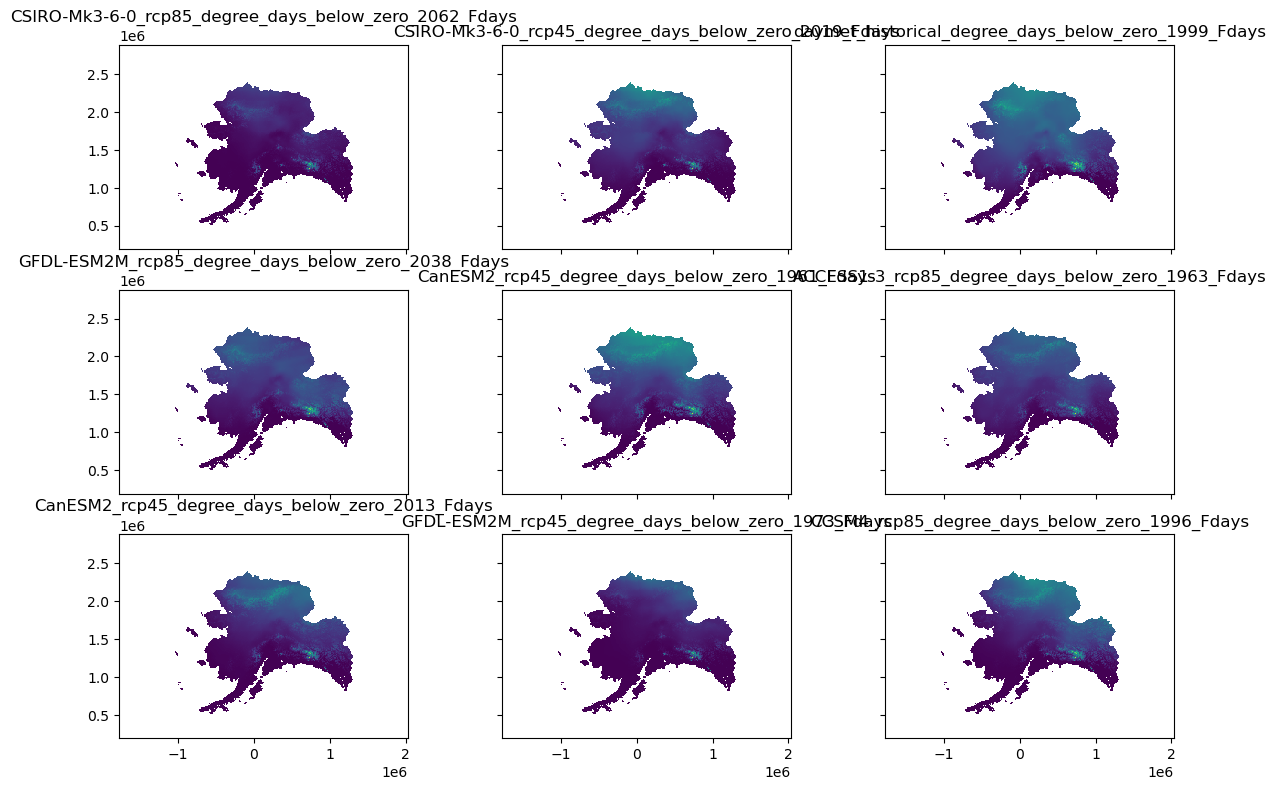

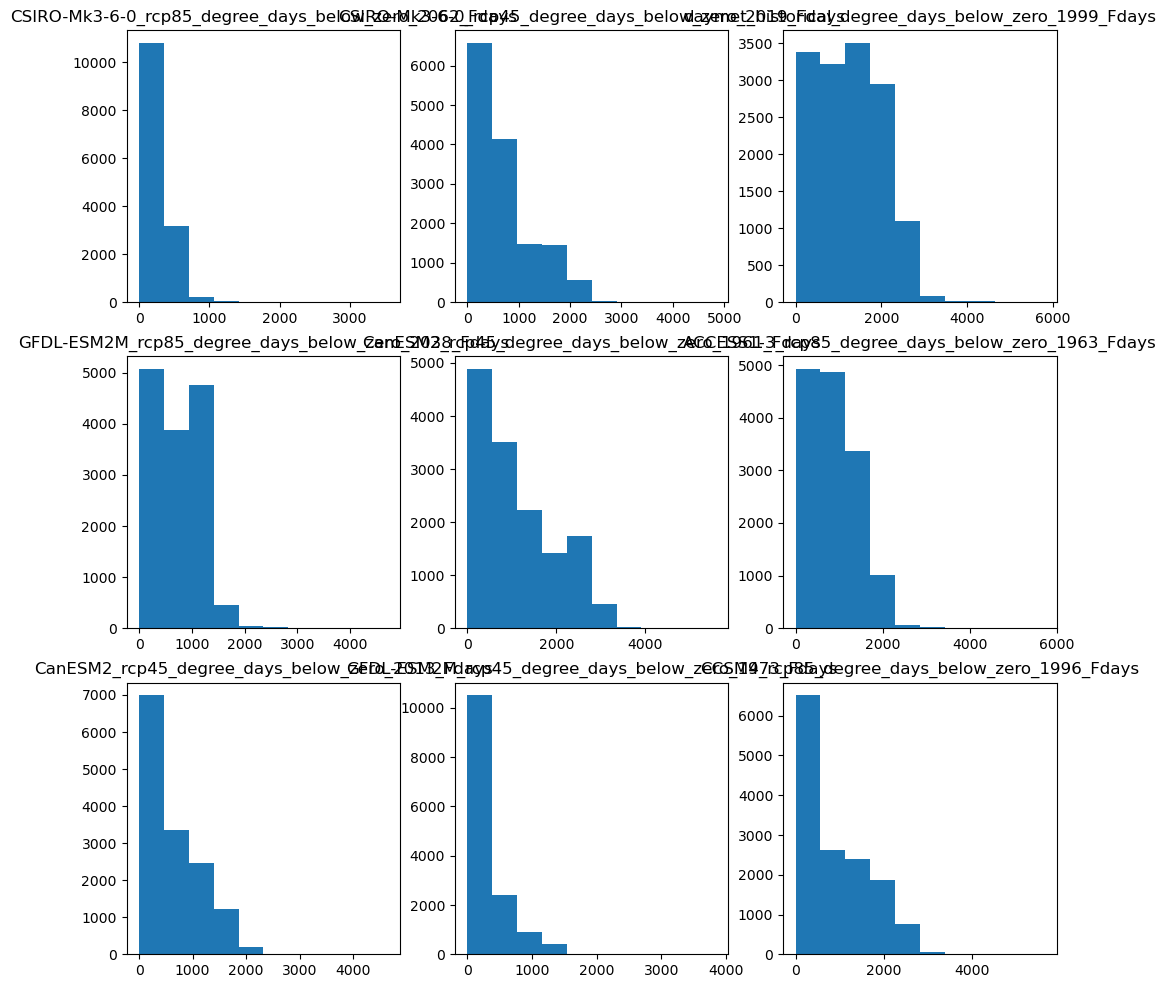

In [7]:
for var in metrics:
    arrs, titles = plot_maps(var)
    plot_histograms(arrs, titles)
